# Utils
With FLUXNET 2015 monthly averaged data, the evaporative stress index (ESI) is computed using the Preistly Taylor equation. The exponential relationship between ESI and relative humidity is then used in conjunction with a simple parameterization of the stress index (detailed below and in [Fisher et al. 2008](https://www.sciencedirect.com/science/article/abs/pii/S0034425707003938)) in order to compute a scalar Beta value describing the curve.<br><br>
*Model parameterization of the stress index:*  <font size='4'>ESI = RH<sup>(VPD*β)</sup></font>, where RH is relative humidity and VPD is vapor pressure deficit.<br><br> Functions defined in this notebook are used in other notebooks to solve for β and evaluate the model.

**Input:** 
 - FLUXNET 2015 monthly csv from data_wrangling.ipynb

**Output:**
 - Figures

## Import notebook dependencies

In [1]:
import pandas as pd 
import numpy as np 
import os
from scipy import optimize
import matplotlib.pyplot as plt

#increase resolution of plots in jupyter notebook
%config InlineBackend.figure_format = 'retina'

## Define functions used in calculation

### Convert degrees Celcius to degrees Kelvin 
FLUXNET temperatures are given in Celcius, but the equations used in the calculation require degrees Kelvin

In [2]:
def kelvin(Tc): 
    """Convert degrees Celcius to degrees Kelvin
    Args: 
        - Tc (float): temperature in Celcius
    Returns: 
        - Tk (float): temperature in Kelvin
    """
    Tk = Tc + 273.15
    return Tk

### Calculate latent heat of vaporatization 
Latent heat of vaporization is defined as the amount of heat that must be added to a liquid in order to convert it to a gas. It is a function of temperature. 

In [3]:
def Lambda(Tc): 
    """Calculate latent heat of vaporization
    Args: 
        - Tc (float): Temperature in Celcius
    Returns: 
        - Lv (float): Latent heat of vaporization at input temperature in units of J/kg 
    """
    Lv = 3149000 - 2370*kelvin(Tc) #J/kg   
    return Lv

### Calculate saturation vapor pressure

The saturation vapor pressure is defined at the pressure where water is saturated but not supersaturated, meaning the water is at equilibrium between its gaseous state (water vapor) and its condensed state (liquid water).

In [4]:
def satVapor(Tc):
    """Calculate saturation vapor pressure at a given temperature
    Args: 
        - Tc (float): Temperature in Celcius
    Returns: 
        - Vp (float): Saturation vapor pressure in units of Pa
    """
    A = 611 #Pa
    B = -5310 #K
    T0 = 273 #K
    Tk = kelvin(Tc) #K
    Vp = A*np.exp(B*((1/Tk)-(1/T0))) #Pa
    return Vp

### Calculate slope of saturation vapor pressure curve
Define a function that calculates the derivative of the saturation vapor curve with respect to temperature. A plot of this curve (and the code used to generate it) can be viewed by clicking the plus icon. 

```{note} 
Some code is hidden for better readability. Hidden code can be viewed by clicking the plus sign.
```

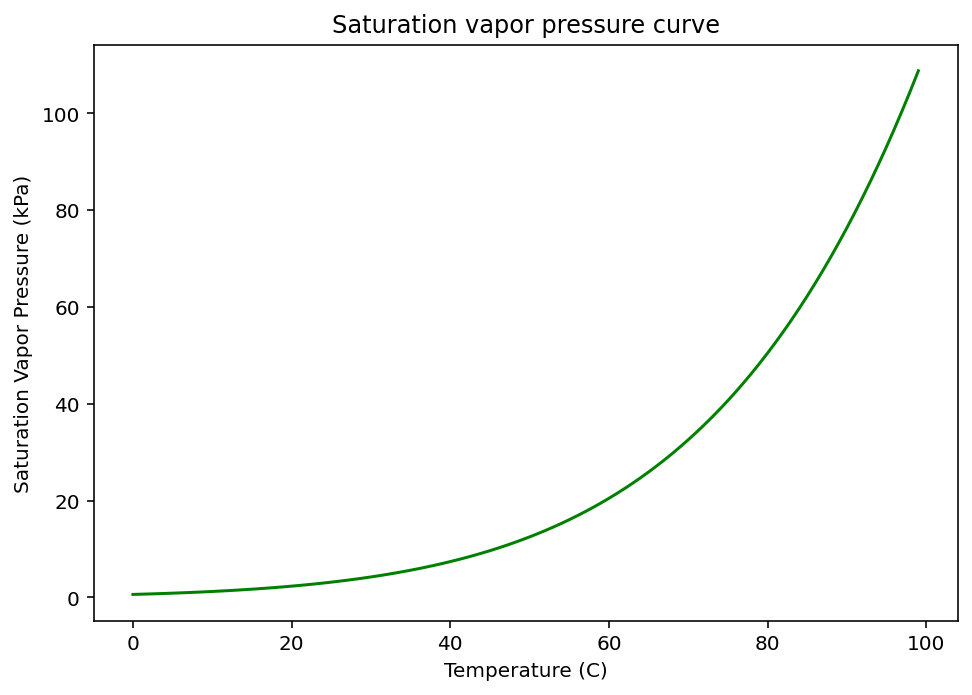

In [5]:
#plot saturation vapor pressure curve using function defined above
Tc = np.arange(0,100,1) #array of temps, 1-100 C
sV = [satVapor(T)/1000 for T in Tc] #saturation vapor pressure in kPa

#initialize figure and axes
fig = plt.figure(figsize = (6,4))
ax = plt.axes([0,0,1,1])

#plot and display data
plt.plot(Tc, sV, color = 'green') #plot curve
plt.ylabel('Saturation Vapor Pressure (kPa)')
plt.xlabel('Temperature (C)')
plt.title('Saturation vapor pressure curve');

In [6]:
def slope(Tc): 
    """Calculate the slope of the sat vapor curve 
    Args:
        - Tc (float): Temperature in Celcius
    Returns: 
        - s (float): Slope at Tc in units of Pa/K
    """
    C = 5310
    T = kelvin(Tc) #K
    s = (C*satVapor(Tc))/T**2 #Pa/K
    return s

### Calculate the psychronmetric constant
Although this value is called a constant, it actual differs with temperature and pressure. The function below calculates the psychronmetric constant from an input temperature and pressure values. This constant is used to calculate potential evapotranspiration in the Priestley Taylor equation.

In [7]:
def gamma(P,Tc):
    """Calculate the psychronmetric constant
    Args: 
        - Tc (float): Temperature in Celcius
        - P (float): pressure in kPa
    Returns: 
        - gamma (float): psychronmetric constant in units of Pa/K
    """
    Cp = 1005 #molar specific heat of dry air, J/(kg*K)
    Pa = 1000*P #convert kPa to Pa
    gamma = (Cp*Pa)/(Lambda(Tc)*0.622) #Pa/K
    return gamma

## Load data file from repository

In [8]:
pathname = 'data/FLUXNET2015_monthly.csv'
fluxMonthly = pd.read_csv(pathname)
display(fluxMonthly[:5])

,DATE,FLUXNET-ID,IGBP,LE (W/m^2),VPD (kPa),TA (deg C),NETRAD (W/m^2),G (W/m^2),PA (kPa),RH,Std Dev RH
0,2011-01-01,US-CRT,CRO,5.317504,0.101241,-5.489418,9.618696,-4.961629,99.831905,0.757487,0.102424
1,2011-02-01,US-CRT,CRO,11.828405,0.145528,-2.971717,20.088240,-0.771094,99.859839,0.737630,0.134346
2,2011-03-01,US-CRT,CRO,34.717653,0.197390,2.153819,92.061066,11.126964,100.084974,0.747895,0.144803
3,2011-04-01,US-CRT,CRO,45.258565,0.307019,7.368077,96.613316,11.045620,99.294018,0.737826,0.150827
4,2011-05-01,US-CRT,CRO,82.249253,0.444950,15.870246,143.585133,13.552872,99.448677,0.794998,0.157474


## Calculate ESI using the Priestley Taylor equation
The evaporative stress index (ESI) is defined as the ratio of actual evapotranspiration over potential evapotranspiration.<br><br>We can calculate potential evapotranspiration using the Priestly Taylor equation (defined in code below) and inputs from the FLUXNET monthly data. Actual evapotranspiration is given as the column LE (Latent heat flux) in the table above.

### Define a function to calculate potential evapotranspiration
Put the Priestly Taylor equation into python code.

In [9]:
def E_pot(Tc, P, NETRAD, G): 
    """
    Args: 
        - Tc (float): Temperature in Celcius
        - P (float): Pressure in kPa
        - NETRAD (float): Net radiation in W/m^2
        - G (float): Soil heat flux in W/m^2
    Returns: 
        - E_pot (float): potential evapotranspiration in units of W/m^2
    """
    s = slope(Tc)
    p = gamma(P,Tc)
    E_pot = 1.26*(s/(s+p))*(NETRAD - G) #W/m^2
    return E_pot

### Calculate ESI and add as a column to the table
Use the function above and the Latent Heat Flux (**LE**) column in the data table to calculate ESI. Add these calculations as a column to the table, labeled **ESI PT** for Evaporative Stress Index (ESI), Priestly Taylor (PT).<br><br>Because ESI is a ratio, we would expect that all values are between 0 and 1. All values that fall outside that range will be counted as errors and removed.

In [10]:
def addESI_PT(fluxMonthly, upperLimit = 1): 
    """Calculate ESI PT and add as a column to the table 
    Args: 
        - fluxMonthly (pandas DataFrame): dataframe containing fluxnet monthly data
        - upperLimit (int, optional): upper limit to restrict ESI ratio (default to 1)
    Returns: 
        - fluxDF (pandas DataFrame): dataframe with new 'ESI PT (W/m^2)' column
    """
    fluxDF = fluxMonthly.copy()

    #pull data from columns in table
    Tc = fluxDF['TA (deg C)'].values
    P = fluxDF['PA (kPa)'].values
    NETRAD = fluxDF['NETRAD (W/m^2)'].values
    G = fluxDF['G (W/m^2)'].values
    LE = fluxDF['LE (W/m^2)'].values

    #calculate potential evapotranspiration for each row of table
    EPot = [E_pot(Tc[i], P[i], NETRAD[i], G[i]) for i in range(len(fluxDF))]
    EPot[EPot == 0] = np.nan 
    
    #calculate ESI
    ESI_PT = LE/EPot 

    #add as column to table
    fluxDF.insert(loc = 3, column = 'ESI PT (W/m^2)', value = ESI_PT)

    #drop any rows where ESI < 0 or greater than 1
    fluxDF = fluxDF.loc[fluxDF['ESI PT (W/m^2)'] <= upperLimit].loc[fluxDF['ESI PT (W/m^2)'] >= 0].reset_index(drop = True)
    #print(str(round(((len(fluxMonthly)-len(fluxDF))/len(fluxMonthly))*100,1)) + ' % data removed because ESI > ' + str(upperLimit) + ' or ESI < 0')
 
    return fluxDF

Call function to add as a column to the table

In [11]:
fluxMonthly = addESI_PT(fluxMonthly)

### Plot ESI
Here we will plot ESI vs. RH and calculate a line of best fit for the curve

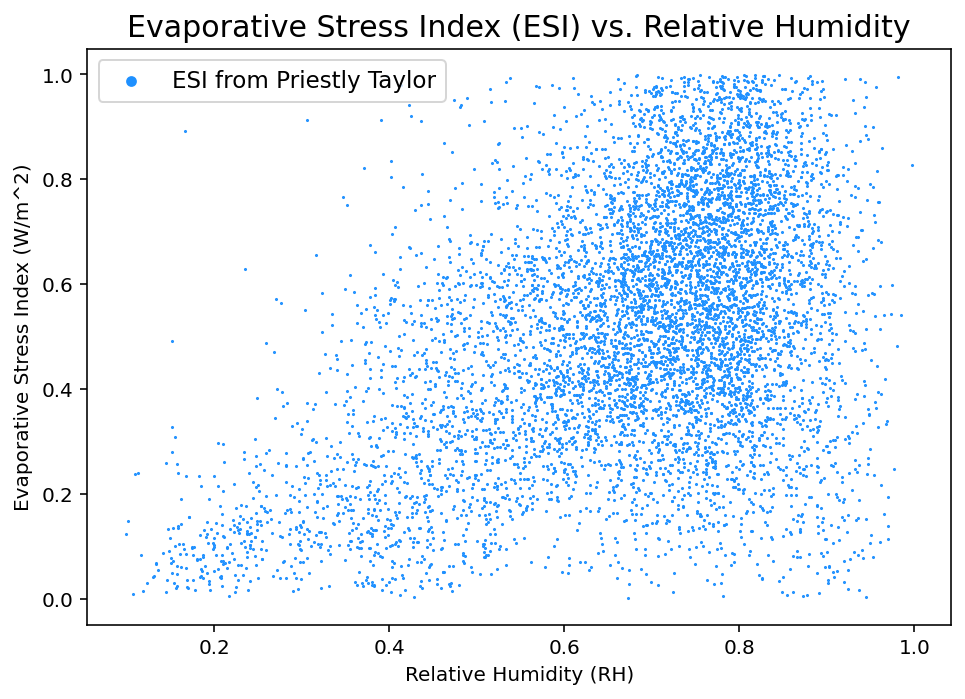

In [12]:
#initialize figure and axes
fig = plt.figure(figsize = (6,4))
ax = plt.axes([0,0,1,1])

#plot data
ax.scatter(fluxMonthly['RH'].values, fluxMonthly['ESI PT (W/m^2)'].values, s = 0.3, color = 'dodgerblue');

#add descriptive info to plot
plt.ylabel('Evaporative Stress Index (W/m^2)')
plt.xlabel('Relative Humidity (RH)')
plt.legend(['ESI from Priestly Taylor'], markerscale = 8, fontsize = 11.5)
plt.title('Evaporative Stress Index (ESI) vs. Relative Humidity', fontsize = 15);

## Use ESI parameterization and FLUXNET data to calculate β
Now we want to fit the ESI parameterization to the curve of Relative Humidity (RH) vs. Evaporative Stress Index, generated using the FLUXNET 2015 monthly data.<br><br>
*Model parameterization of the stress index:*  <font size='4'>ESI = RH<sup>(VPD*β)</sup></font>
<br>Where RH is relative humidity and VPD is vapor pressure deficit. 

The goal is to find the scalar β value that best describes the curve.

### Define a function to minimize β 

To find the scalar β value that best describes the curve, we can use the <span style="color:darkmagenta; font-family: Courier">scipy.optimize.minimize</span> function to minimize the residuals and solve for β. See [this post on Medium](https://mmas.github.io/least-squares-fitting-numpy-scipy) by Modesto Mas for more info on the method used, and [SciPy documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize_scalar.html) for more info on how the minimize function works.

In [13]:
def minimize_b(x, y, VPD): 
    """Calculate Beta value by minimizing residuals
    Args: 
        - x (numpy array): Relative humidity from FLUXNET monthly (x-values of plot) 
        - y (numpy array): Evaporative stress index, calculated using Priestly Taylor equation and inputs from FLUXNET monthly (y-values of plot)
        - VPD (numpy array): Vapor pressure deficit in units of kPa from FLUXNET monthly
    Returns: 
        - Beta (float): Beta value, rounded to 2 decimals
    """
    #ESI parameterization
    def f(x,B):
        return x**(VPD*B)

    #Calculate residuals
    def residual(B, x, y):
        return y - f(x,B)
    
    #Minimize residuals
    def min_residual(B, x, y):
        return sum(residual(B, x, y)**2)

    #Using functions defined, minimize residuals using scipy.optimize.minimize
    B0 = 1 #initial guess at value of Beta
    method = 'L-BFGS-B' #method used to minimize a scalar
    res = optimize.minimize(min_residual, B0, method = method, args = (x, y)) 
    Beta = round(res.x[0],2)
    return Beta

### Calculate β for all flux towers in the FLUXNET 2015 dataset

In [14]:
RH = fluxMonthly['RH'].values #np array of values 
ESI_PT = fluxMonthly['ESI PT (W/m^2)'].values #np array of values 
VPD = fluxMonthly['VPD (kPa)'].values #np array of values 
betaAll = minimize_b(x = RH, y = ESI_PT, VPD = VPD)

### Use parameterization to calculate ESI 

Define a function that calculates ESI using the parameterization and an input β value. 

In [15]:
def f_RH(RH,VPD,B): 
    """ESI parameterization
    Args: 
        - RH (float): Relative humidity (0-1)
        - VPD (float): Vapor pressure deficit in units of kPa
        - B (float): Beta value
    Output: 
        -ESI_B (float): Evaporative stress index, calculated using parameterization in units of W/m^2
    """
    ESI_B = RH**(VPD*B) #W/m^2
    return ESI_B 

Using the function above and the calculated β value, calculate and plot the evaporative stress index.

In [16]:
#calculate ESI
ESI_B = [f_RH(RH[i],VPD[i],B = betaAll) for i in range(len(fluxMonthly))]

#add as column to table
fluxMonthly.insert(loc = 4, column = 'model ESI (W/m^2)', value = ESI_B)

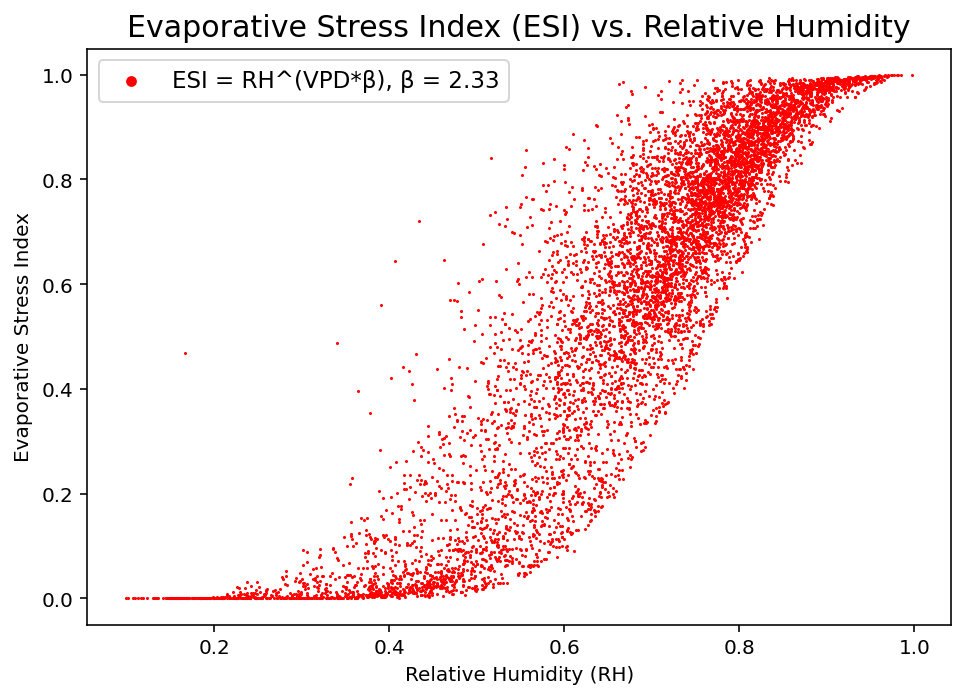

In [17]:
#initialize figure and axes
fig = plt.figure(figsize = (6,4))
ax = plt.axes([0,0,1,1])

#plot data
ax.scatter(fluxMonthly['RH'].values, ESI_B, s = 0.3, color = 'red');

#add descriptive info to plot
plt.ylabel('Evaporative Stress Index')
plt.xlabel('Relative Humidity (RH)')
plt.legend(['ESI = RH^(VPD*β), β = ' + str(betaAll)], markerscale = 8, fontsize = 11.5)
plt.title('Evaporative Stress Index (ESI) vs. Relative Humidity', fontsize = 15);

## Evaluate model 
Above, we calculated the actual ESI using the Priestly Taylor equation at the start of the notebook, and the model ESI using the Fisher parameterization in the cells above. Next, we want evaluate how well the simple parameterization works in describing the evaporative stress index. 

### Plot actual and model ESI
Overlaying the two plots of ESI from earlier in the book by plotting the Priestly Taylor ESI and the model ESI on the same axis.

In [18]:
def plotESI(RH, ESI_PT, ESI_B, Beta, title = 'Evaporative Stress Index (ESI) vs. Relative Humidity', markersize = 0.8, figPath = None): 
    """Plot actual and model ESI 
    Args: 
        - RH (np array): Relative humidity
        - ESI_PT (np array): ESI from Preistly Taylor
        - ESI_B (np array): Model ESI 
        - Beta (np array): Beta value used in model calculation 
        - title (str, optional): Title for the plot (defaults to 'Evaporative Stress Index (ESI) vs. Relative Humidity')
        - marksize (float, optional): Size of markers in scatter plot (defaults to 0.3)
        - figPath (str, optional): Path to save figure to (defaults to None-- figure not saved)
    Returns: 
        - Scatter plot displayed in notebook
    """
    #initialize figure and axes
    fig = plt.figure(figsize = (6,4))
    ax = plt.axes([0,0,1,1])

    #plot data
    ax.scatter(RH, ESI_B, s = markersize, color = 'red', label = 'f(RH) = RH^(VPD/β), β = ' + str(round(1/Beta,2))); #model ESI
    ax.scatter(RH, ESI_PT, s = markersize, color = 'dodgerblue', label = 'ESI tower data');

    #add descriptive info to plot
    plt.ylabel('Evaporative Stress Index')
    plt.xlabel('Relative Humidity')
    plt.xticks(np.arange(0,1+0.2, 0.2))
    plt.yticks(np.arange(0,1+0.2, 0.2))
    plt.legend(markerscale = 3, fontsize = 11.5, loc = 'upper left')
    plt.title(title, fontsize = 15)
    
    #save figure
    if figPath != None: 
        plt.savefig(figPath, bbox_inches='tight', dpi = 350)
    
    #display plot
    plt.show()

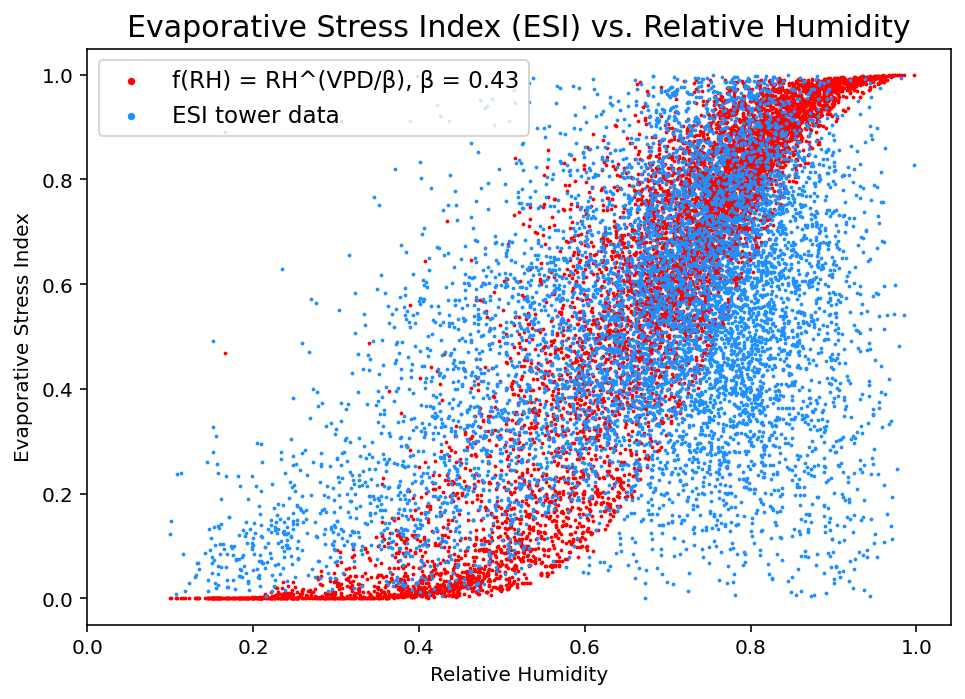

In [19]:
plotESI(RH = fluxMonthly['RH'].values, ESI_PT = fluxMonthly['ESI PT (W/m^2)'].values, ESI_B = fluxMonthly['model ESI (W/m^2)'], Beta = betaAll)

### Calculate residuals
Calculate the distance between points to understand the efficacy of the model. To do this, we'll calculate the residual between points at the same relative humidity.

In [20]:
residuals = np.array([fluxMonthly['model ESI (W/m^2)'][i]-fluxMonthly['ESI PT (W/m^2)'][i] for i in range(len(fluxMonthly['ESI PT (W/m^2)']))])
SSR = np.mean(np.abs(residuals**2))
print('Sum of squared residuals = ' + str(round(SSR,3)))

Sum of squared residuals = 0.102


### Plot residuals 
Generating a scatter plot of the residuals will allow us to visualize trends in the residuals, and better understand where the model succeeds and where it may fail. 

In [21]:
def plotResiduals(RH, residuals, title = 'Relative Humidity vs. Residuals', figPath = None): 
    """Plot residuals 
    Args: 
        - RH (np array): Relative humidity from FLUXNET monthly (x-values of plot) 
        - residuals (np array): residuals from model ESI - actual ESI 
        - title (str, optional): Title for the plot (defaults to 'Relative Humidity vs. Residuals')
        - figPath (str, optional): Path to save figure to (defaults to None-- figure not saved)
    Returns: 
        - scatter plot of residuals 
    """
    #initialize figure and axes
    fig = plt.figure(figsize = (6,4))
    ax = plt.axes([0,0,1,1])

    #plot data
    plt.scatter(RH, residuals, color = 'magenta', s = 3, label = 'Residual ')
    plt.hlines(y = 0, xmin = 0, xmax = 1, color = 'black', linestyle = '--', label = 'y = 0')

    #add descriptive info to figure
    plt.xlabel('Relative Humidity')
    plt.ylabel('Residual')
    plt.ylim(bottom = -1.05, top = 1.05)
    plt.title(title)
    plt.legend(markerscale = 3, fontsize = 11.5)

    #save figure
    if figPath != None: 
        plt.savefig(figPath, bbox_inches='tight', dpi = 350)
    
    #display figure 
    plt.show()

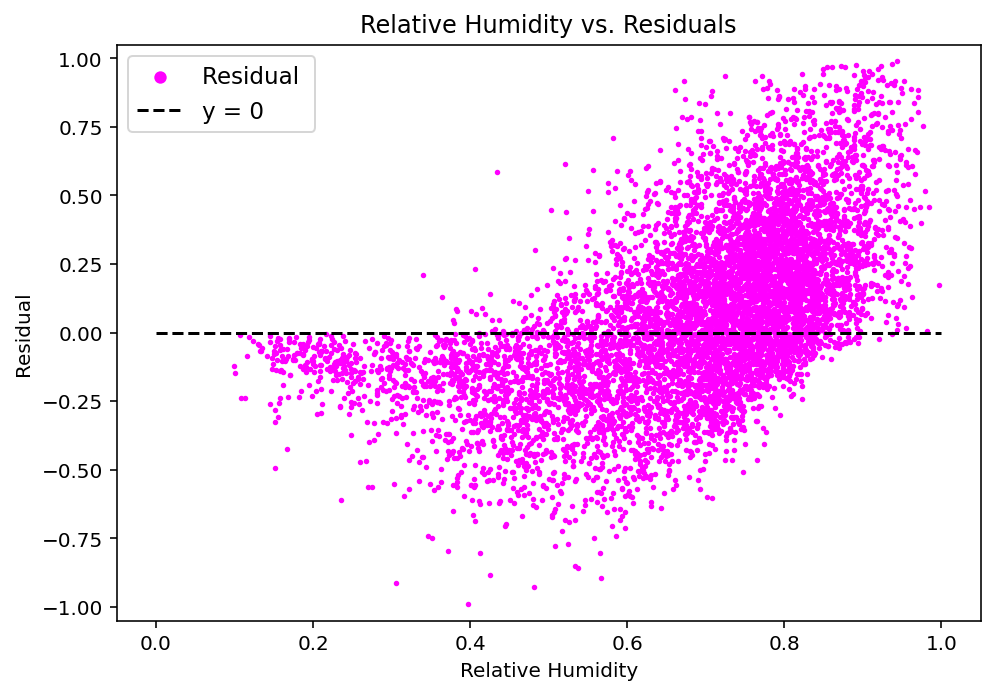

In [22]:
plotResiduals(RH = fluxMonthly['RH'].values, residuals = residuals)

A perfect fit would have all the residuals equal to zero, indicating that there is no difference in the actual and model calculation. Instead, the Fisher parameterization seems to underestimate ESI at low relative humidity and overestimate ESI at high relative humidity, indicated by negative residuals in the middle of the plot and large positive residuals closer to RH = 1.<br><br>